In [1]:
pip install torchtoolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 951.9 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 2.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

import os
from tqdm import tqdm
import itertools

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import WeightedRandomSampler
from torchtoolbox.transform import Cutout

torch.backends.cudnn.benchmark = True

In [4]:
#data_ds = "/kaggle/input/ai-cup-dataset/target/target"
data_ds = "/kaggle/input/science/four_target"
#datatest_ds = "../input/aicup-crops/test"
classes = os.listdir(data_ds)
classes.remove(".check_jpg.py.swp")
print(classes)

['TA', 'IA', 'AA', 'NFP']


In [5]:
import shutil

# shutil.rmtree('/kaggle/temp/')
    
num = 0
valid_num = [2000, 450, 250, 1200]
#valid_num = 200

for aclass in classes:
    print('Copying', aclass)
    src_ds = os.path.join(data_ds, aclass)
    #src_ds=os.path.join(src_ds, aclass)
    train_cd = os.path.join('/kaggle/s12/train', aclass)
    valid_cd = os.path.join('/kaggle/s12/valid', aclass)
    os.makedirs(train_cd)
    os.makedirs(valid_cd)
    
    files = os.listdir(src_ds)
    for f in files[valid_num[num]:]:
        src = os.path.join(src_ds, f)
        dst = os.path.join(train_cd, f)
        shutil.copy(src, dst)
    num += 1
    #for f in files[:valid_num]:
    for f in files[:]:
        src = os.path.join(src_ds, f)
        dst = os.path.join(valid_cd, f)
        shutil.copy(src, dst)

Copying TA
Copying IA
Copying AA
Copying NFP


In [6]:
transforms = T.Compose([
    T.Resize((1024, 1024)),
    T.RandomHorizontalFlip(p=0.5),
    #T.RandomVerticalFlip(0.5),
    #T.RandomRotation(10),
    #T.RandomEqualize(p=1),
    #Cutout(),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    #T.GaussianBlur(7,3)

])
train_ds = ImageFolder('/kaggle/s12/train', transform = transforms)
val_ds = ImageFolder('/kaggle/s12/valid', transform = transforms)

In [7]:
random_seed = 42
torch.manual_seed(random_seed)

In [8]:
len(train_ds), len(val_ds)

(1395, 5295)

In [9]:
batch_size = 16

In [10]:
train_y = [label for img, label in train_ds.samples ]

class_sample_count = np.array([len(np.where(train_y == t)[0]) for t in np.unique(train_y)])
print(class_sample_count)
# sample_weight=[]
# for i in class_sample_count:
#     sample_weight.append(1/i)
# print(sample_weight)

[177 446 337 435]


In [11]:
# train_dl = DataLoader(train_ds, batch_size, num_workers = 2, sampler=sampler, pin_memory=True)
train_dl = DataLoader(train_ds, batch_size, num_workers = 2, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 2, pin_memory=True)

In [12]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

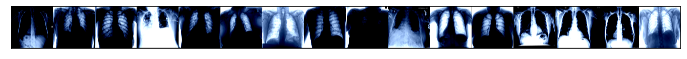

In [13]:
show_batch(train_dl)

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
#改batch

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def predict_step(self, batch, y_pred, y_true):
        images, labels = batch 
        out = self(images)  # Generate predictions
        _, preds = torch.max(out, 1)
        loss = F.cross_entropy(out, labels)   # Calculate loss
        y_pred.extend(preds.view(-1).detach().cpu().numpy())       # 將preds預測結果detach出來，並轉成numpy格式       
        y_true.extend(labels.view(-1).detach().cpu().numpy())      # target是ground-truth的label
        #acc = accuracy(out, labels)           # Calculate accuracy
        return y_pred, y_true
        #return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        torch.save(self.network.state_dict(), '/kaggle/working/model-' + str(epoch) + '.pth')
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [17]:
@torch.no_grad()
def predict(model, val_loader, y_pred, y_true):
    model.eval()
    for batch in val_loader:
        y_pred, y_true=model.predict_step(batch, y_pred, y_true)
    #outputs = [model.validation_step(batch) for batch in tqdm(val_loader)]
    return y_pred, y_true

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, y_pred, y_true, opt_func=torch.optim.AdamW):
    history = []
    optimizer = opt_func(model.parameters(), lr)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-5)
    for epoch in tqdm(range(epochs)):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            optimizer.zero_grad()
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            #print('optim: {}'.format(optimizer.param_groups[0]['lr']))
            optimizer.step()
#         print('scheduler: {}'.format(scheduler.get_lr()[0]))
#         scheduler.step()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        predict(model, val_dl, y_pred, y_true )
        target_names=['AA', 'IA', 'NFP', 'TA']
        #target_names=['sesbania', 'broccoli', 'soybeans', 'sunhemp', 'passionfruit', 'lettuce', 'papaya', 'bambooshoots', 'kale', 'pear', 'litchi', 'asparagus', 'cauliflower', 'chinesecabbage', 'tea', 'longan', 'custardapple', 'roseapple', 'loofah', 'greenonion', 'taro', 'chinesechives', 'waterbamboo', 'lemon', 'sweetpotato', 'betel', 'pennisetum', 'redbeans', 'greenhouse', 'grape', 'mango', 'onion', 'others']
        #target_names = ['tomato', 'pineapple', 'pumpkin', 'carrot', 'guava', 'peanut', 'bareland', 'dragonfruit', 'sugarcane', 'soybean', 'corn', 'banana', 'garlic', 'rice']
        cnf_matrix = confusion_matrix(y_true, y_pred)
        per_cls_acc = cnf_matrix.diagonal()/cnf_matrix.sum(axis=0)                    # https://stackoverflow.com/a/53824126/13369757
        print(target_names)
        print(per_cls_acc)                                                          #顯示每個class的Accuracy
        print("Plot confusion matrix")

        # 開始繪製混淆矩陣
        df_cm = pd.DataFrame(cnf_matrix, target_names, target_names)     # https://sofiadutta.github.io/datascience-ipynbs/pytorch/Image-Classification-using-PyTorch.html
        plt.figure(figsize = (4,4))
        sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
        plt.xlabel("prediction")
        plt.ylabel("label (ground truth)")
        y_pred=[]
        y_true=[]
    return history

In [18]:
from torch.cuda.amp import autocast
class ConvNeXt(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        #self.network = timm.create_model('convnext_small', pretrained=True)
        self.network = timm.create_model('efficientnet_b0', pretrained=True)
        # Replace last layer
        num_ftrs = self.network.num_features
        self.network.classifier = nn.Linear(num_ftrs, 4)
    
    @autocast()
    def forward(self, xb):
        return self.network(xb)

model = ConvNeXt()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [19]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ConvNeXt(
  (network): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1

In [20]:
model = to_device(ConvNeXt(), device)
#evaluate(model, val_dl)

In [21]:
y_pred=[]
y_true=[]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: train_loss: 1.2598, val_loss: 1.1543, val_acc: 0.5127


 10%|█         | 1/10 [22:56<3:26:29, 1376.59s/it]

['AA', 'IA', 'NFP', 'TA']
[0.27272727 0.20818505 0.77024793 0.64616448]
Plot confusion matrix
Epoch 2: train_loss: 1.1162, val_loss: 1.1406, val_acc: 0.5178


 20%|██        | 2/10 [46:56<3:08:28, 1413.58s/it]

['AA', 'IA', 'NFP', 'TA']
[0.19370079 0.25110132 0.56730342 0.83594976]
Plot confusion matrix
Epoch 3: train_loss: 1.0127, val_loss: 1.1094, val_acc: 0.5216
['AA', 'IA', 'NFP', 'TA']
[0.36875    0.25985401 0.64651163 0.82473498]
Plot confusion matrix


 30%|███       | 3/10 [1:11:12<2:47:11, 1433.10s/it]

Epoch 4: train_loss: 0.8882, val_loss: 1.2422, val_acc: 0.4659


 40%|████      | 4/10 [1:35:03<2:23:14, 1432.42s/it]

['AA', 'IA', 'NFP', 'TA']
[0.35174419 0.24190912 0.78711485 0.88879457]
Plot confusion matrix
Epoch 5: train_loss: 0.6895, val_loss: 1.3701, val_acc: 0.4946


 50%|█████     | 5/10 [1:58:50<1:59:12, 1430.53s/it]

['AA', 'IA', 'NFP', 'TA']
[0.36842105 0.26158382 0.67971759 0.84024896]
Plot confusion matrix
Epoch 6: train_loss: 0.5244, val_loss: 1.2744, val_acc: 0.5887


 60%|██████    | 6/10 [2:23:19<1:36:13, 1443.46s/it]

['AA', 'IA', 'NFP', 'TA']
[0.32107023 0.34383754 0.84162304 0.72175649]
Plot confusion matrix
Epoch 7: train_loss: 0.3628, val_loss: 1.7930, val_acc: 0.4999


 70%|███████   | 7/10 [2:47:07<1:11:55, 1438.40s/it]

['AA', 'IA', 'NFP', 'TA']
[0.35607321 0.27154844 0.76265271 0.90280778]
Plot confusion matrix
Epoch 8: train_loss: 0.2104, val_loss: 1.3184, val_acc: 0.6295


 80%|████████  | 8/10 [3:11:14<48:02, 1441.10s/it]  

['AA', 'IA', 'NFP', 'TA']
[0.41423358 0.38555858 0.70869277 0.83013544]
Plot confusion matrix
Epoch 9: train_loss: 0.1908, val_loss: 1.2012, val_acc: 0.6685


 90%|█████████ | 9/10 [3:35:09<23:59, 1439.25s/it]

['AA', 'IA', 'NFP', 'TA']
[0.50815851 0.4322527  0.77998528 0.76345486]
Plot confusion matrix
Epoch 10: train_loss: 0.2328, val_loss: 1.4580, val_acc: 0.6192


100%|██████████| 10/10 [3:58:36<00:00, 1431.68s/it]

['AA', 'IA', 'NFP', 'TA']
[0.75555556 0.3085466  0.84168565 0.81140971]
Plot confusion matrix


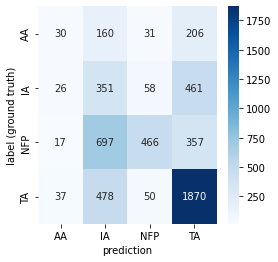

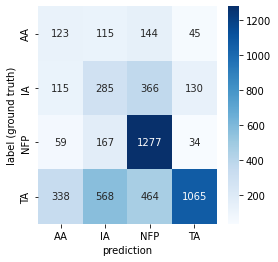

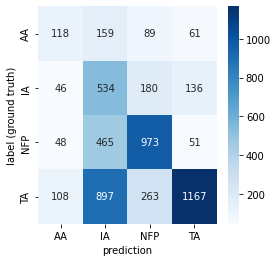

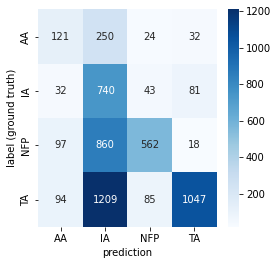

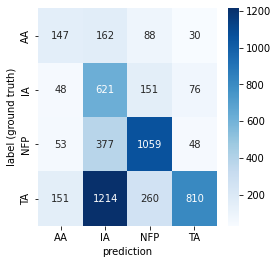

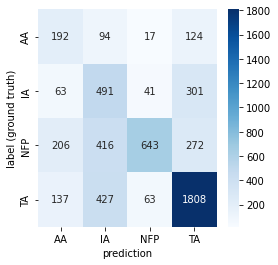

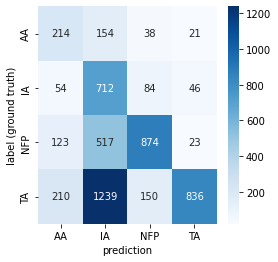

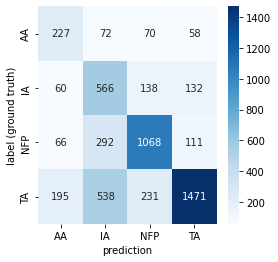

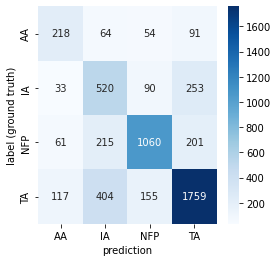

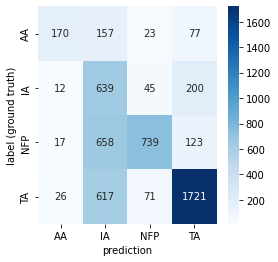

In [22]:
num_epochs = 10
opt_func = torch.optim.AdamW
lr = 3e-4
history = fit(num_epochs, lr, model, train_dl, val_dl, y_pred, y_true, opt_func)

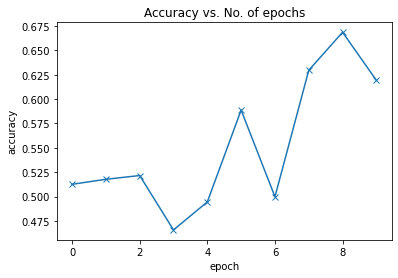

In [23]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)

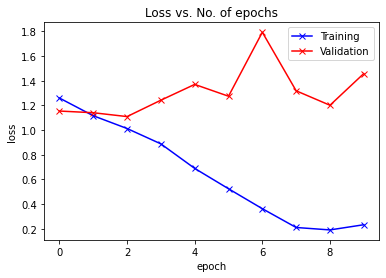

In [24]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

In [25]:
def test(model, dataloader):
    model.eval()
    pred_list =[]
    pred_id_list=[]
    with torch.no_grad():
        with tqdm(dataloader,unit='batch',desc='Test') as tqdm_loader:
            for idx, (imgid, img) in enumerate(tqdm_loader):

                img = img.to(device=cfg['device'])
                pred = model(img).detach().cpu().argmax(dim=1)

                pred_list.append(pred)
                pred_id_list.append(imgid)
    pred_list = np.concatenate(pred_list,axis=0)
    pred_id_list =  np.concatenate(pred_id_list,axis=0)
    return pred_list,pred_id_list
pred_list,pred_id_list = test(model,test_dl)

NameError: name 'test_dl' is not defined

In [ ]:
pred_id_list = [imageid+'.jpg' for imageid in pred_id_list]

In [ ]:
submit_df  = pd.DataFrame(columns=upload_sample_df.columns)
submit_df['image_filename'] = pred_id_list
submit_df['label'] = pred_list
submit_df.to_csv('submit.csv',index=False)
print(submit_df.head(10))